Clone the repository and switch to the IUPWARE_2025 branch

Step 1

In [4]:
!git clone --branch IUPWARE_2025 https://github.com/paulmunozpauta/Course_ML_hydrological_forecasting.git

Cloning into 'Course_ML_hydrological_forecasting'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 762 (delta 89), reused 129 (delta 52), pack-reused 589 (from 1)
Receiving objects: 100% (762/762), 1.08 GiB | 23.43 MiB/s, done.
Resolving deltas: 100% (149/149), done.
Updating files: 100% (440/440), done.


Step 2

In [5]:
ls


Course_ML_hydrological_forecasting/  sample_data/


In [6]:
%cd Course_ML_hydrological_forecasting


/content/Course_ML_hydrological_forecasting


In [7]:
ls

LICENSE  notebooks/  poetry.lock  pyproject.toml  README.md


Step 3

In [8]:
# Install Poetry
!pip install poetry
# Disable virtual environment creation (needed for Colab)
!poetry config virtualenvs.create false

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.2/331.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.7/979.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: keyring
    Found existing installation: keyring 23.5.0
    Uninstalling keyring-23.5.0:
      Successfully uninstalled keyring-23.5.0


Step 4

In [9]:
!poetry install --no-root


Skipping virtualenv creation, as specified in config file.
Installing dependencies from lock file

Package operations: 29 installs, 58 updates, 0 removals

  - Downgrading attrs (25.1.0 -> 24.2.0): Pending...
  - Installing pyrsistent (0.19.3): Pending...
  - Updating traitlets (5.7.1 -> 5.9.0): Pending...
  - Updating traitlets (5.7.1 -> 5.9.0): Pending...
  - Installing pyrsistent (0.19.3): Downloading... 0%
  - Updating traitlets (5.7.1 -> 5.9.0): Pending...
  - Updating traitlets (5.7.1 -> 5.9.0): Pending...
  - Installing pyrsistent (0.19.3): Downloading... 100%
  - Updating traitlets (5.7.1 -> 5.9.0): Pending...
  - Updating traitlets (5.7.1 -> 5.9.0): Pending...
  - Installing pyrsistent (0.19.3): Installing...
  - Updating traitlets (5.7.1 -> 5.9.0): Pending...
  - Updating traitlets (5.7.1 -> 5.9.0): Downloading... 0%
  - Installing pyrsistent (0.19.3): Installing...
  - Updating traitlets (5.7.1 -> 5.9.0): Downloading... 0%
  - Downgrading attrs (25.1.0 -> 24.2.0): Downloadin

Now let's start wit the hands-on course



<div style="text-align:center;">
    <img src="https://github.com/paulmunozpauta/Course_ML_hydrological_forecasting/blob/IUPWARE_2025/notebooks/static/imgs/Logo_course.png?raw=1" width="300">
    <p style="margin-top:10px;">paul.andres.munoz@gmail.com<br>paul.munoz@vub.be</p>
</div>


    

# Part 3: Development of hydrological forecasting models

In this session, we will:
   - Develop forecasting models for the mountain catchment

## Import Libraries

In [10]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
import os
import datetime
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from copy import deepcopy
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import itertools
import random

def lagged_dataset(arr, num_steps, additional_arr, new_num_steps):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []
    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)
    result_array = np.array(modified_rows)
    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row[:-1]))  # Exclude last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    return final_result, np.array(excluded_data)[:, None]

def lagged_dataset_pron(arr, num_steps, additional_arr, new_num_steps, lead_time):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []

    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)

    result_array = np.array(modified_rows)

    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row))  # Include last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Shift excluded_data by lead_time
    excluded_data = excluded_data[lead_time:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    # Resize final_result and excluded_data to have the same number of rows
    min_rows = min(final_result.shape[0], excluded_data.shape[0])
    final_result = final_result[:min_rows]
    excluded_data = excluded_data[:min_rows]

    return final_result, np.array(excluded_data)[:, None]


def calculate_hydro_metrics(simulations, evaluation):
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    rmse = np.sqrt(np.mean((evaluation - simulations) ** 2,
                            axis=0, dtype=np.float64))
    pbias = (100 * np.sum(evaluation - simulations, axis=0, dtype=np.float64)
              / np.sum(evaluation))
    r2 = 1 - (np.sum((evaluation - simulations)**2) / np.sum((evaluation - np.mean(evaluation))**2))
    return kge, rmse, pbias, r2
np.random.seed(22)
random.seed(22)

## Select project folder

In [14]:
folder = os.getcwd()+'/notebooks/data/'
folder

'/content/Course_ML_hydrological_forecasting/notebooks/data/'

## Import precipitation data

### Satellite precipitation

Read data from the mountain catchment

In [15]:

# Import satellite precipitation data
precipitation_satellite = pd.read_csv(folder + 'PERSIANN-CCS_UTC_daily_catchment_1.csv', sep=',')

# Rename columns
precipitation_satellite.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Convert 'Date' column to datetime format (without unnecessary dayfirst=True)
precipitation_satellite['Date'] = pd.to_datetime(precipitation_satellite['Date'], format='%Y-%m-%d')

# Set 'Date' as the index
precipitation_satellite.set_index('Date', inplace=True)

# Drop the redundant 'Date' column (this step is no longer needed)
# precipitation_satellite = precipitation_satellite.drop(labels='Date', axis=1)

# Print first rows to verify
print(precipitation_satellite.head())


              1    2    3    6    7    8    9   10   12   13  ...   21   22  \
Date                                                          ...             
2003-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2003-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2003-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2003-01-04  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2003-01-05  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

             23   24   25   26   27   28   31   32  
Date                                                
2003-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-04  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-05  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 27 columns]


In [16]:
precipitation_satellite

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-04,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-09,0.0,0.2,0.48,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,1.2,0.0,0.0,1.41,0.5,0.0,1.22,5.22,2.12,0.5
2023-08-10,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2023-08-11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0


Calculate annual precipitation

In [17]:
# Resample annual precipitation data
data_annual = precipitation_satellite.resample('YE', label='right', closed='right').sum()

Plot average annual precipitation.

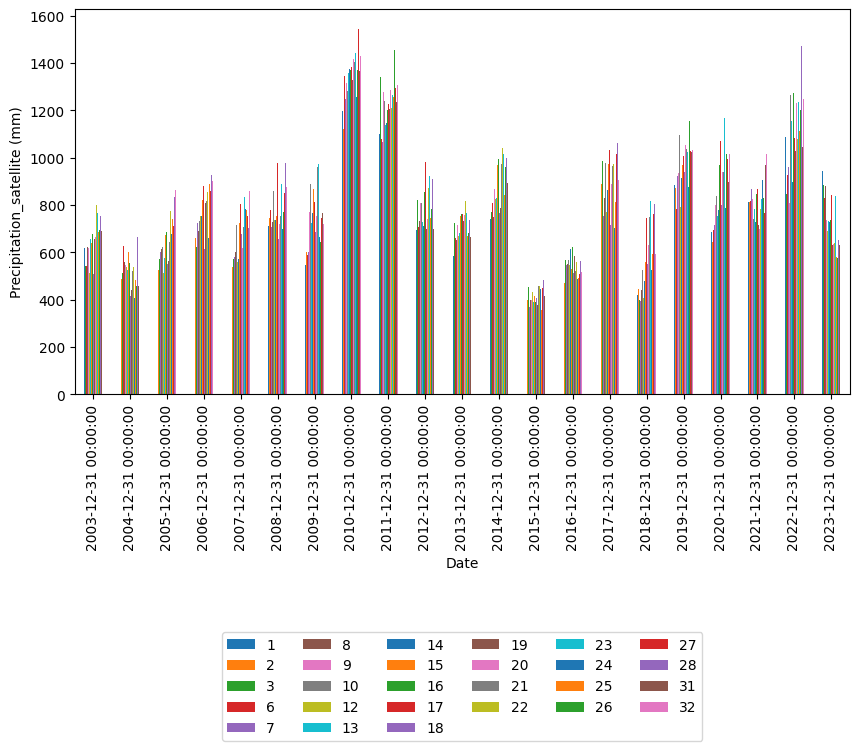

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calculate average annual precipitation for all pixels in the basin.

In [19]:
data_annual_average =  data_annual.mean(axis=1)
data_annual_average

,0
Date,
2003-12-31,646.573704
2004-12-31,518.426667
2005-12-31,647.289630
2006-12-31,785.916296
2007-12-31,688.204074
2008-12-31,783.095185
2009-12-31,757.777407
2010-12-31,1350.764074
2011-12-31,1214.637037


Plot the average precipitation (all pixels).

<ipython-input-20-ed00e46e3b17>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Legend Title')
<ipython-input-20-ed00e46e3b17>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)


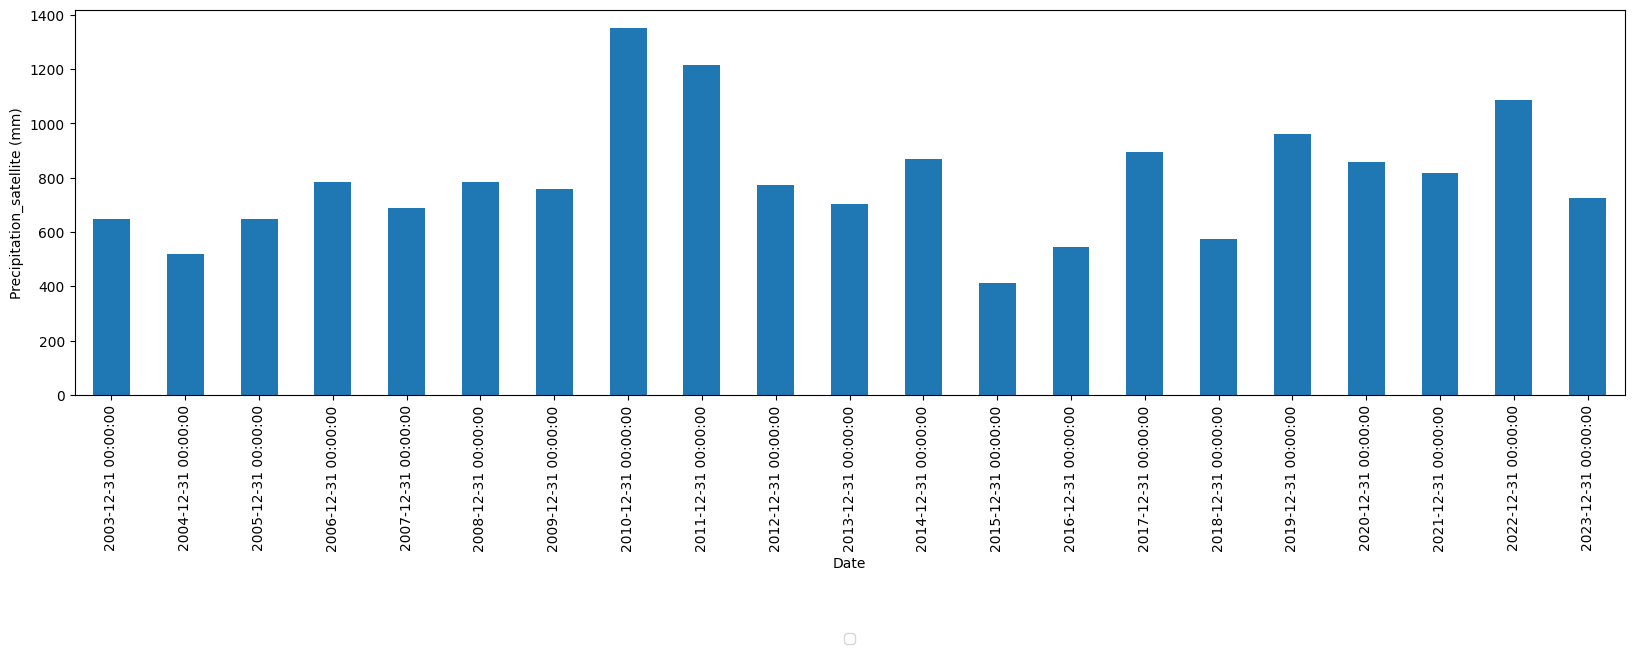

In [20]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual_average.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calculate the average annual precipitation in the basin.

In [21]:
data_annual_average.mean()

791.1507054652681

Calculate monthly precipitation.

In [22]:
data_monthly = precipitation_satellite.resample('M',label='right',closed='right').sum()
data_monthly

<ipython-input-22-10c5075e3e26>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = precipitation_satellite.resample('M',label='right',closed='right').sum()


,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-31,18.53,23.37,29.94,22.73,39.06,42.16,40.16,39.92,29.47,40.56,...,45.47,53.39,56.34,33.75,41.68,56.50,51.82,43.20,48.60,52.30
2003-02-28,75.35,76.53,40.15,41.76,50.23,51.24,51.58,51.47,39.63,40.90,...,55.21,46.67,38.47,29.85,33.75,36.01,54.97,42.35,41.17,49.25
2003-03-31,33.84,33.78,61.99,33.31,32.94,43.43,47.93,47.92,35.19,38.17,...,127.65,113.41,85.31,39.25,58.83,69.97,100.33,111.59,65.35,85.21
2003-04-30,67.83,39.61,36.54,116.87,111.30,71.06,55.90,97.56,57.83,77.65,...,96.13,138.09,81.70,70.13,94.21,92.85,60.37,117.50,90.72,143.74
2003-05-31,1.64,1.03,1.03,1.46,2.47,3.91,3.65,1.57,3.52,5.11,...,1.94,2.21,33.88,0.00,1.18,1.96,2.32,7.70,1.22,2.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,282.20,300.62,318.64,317.19,328.45,308.91,289.28,270.67,312.74,321.06,...,272.43,255.13,300.12,279.92,244.27,247.67,285.49,250.60,245.79,238.41
2023-05-31,142.07,110.56,74.78,81.62,63.36,58.01,59.44,68.27,83.39,50.48,...,56.28,57.32,96.61,35.55,47.45,43.04,43.20,41.47,44.51,54.98
2023-06-30,13.84,8.62,7.92,7.50,8.57,13.41,7.89,7.35,5.23,5.58,...,4.95,9.65,3.56,4.03,2.21,4.31,9.20,5.95,6.88,21.07


Calculate monthly precipitation.

In [23]:
data_monthly_mean_pixels =  data_monthly.mean(axis=1)
data_monthly_mean_pixels

,0
Date,
2003-01-31,40.502593
2003-02-28,45.911111
2003-03-31,60.481111
2003-04-30,84.432963
2003-05-31,3.860370
...,...
2023-04-30,283.854074
2023-05-31,64.770370
2023-06-30,7.100000


Plot

<ipython-input-24-96c4114efcd8>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Legend Title')
<ipython-input-24-96c4114efcd8>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)


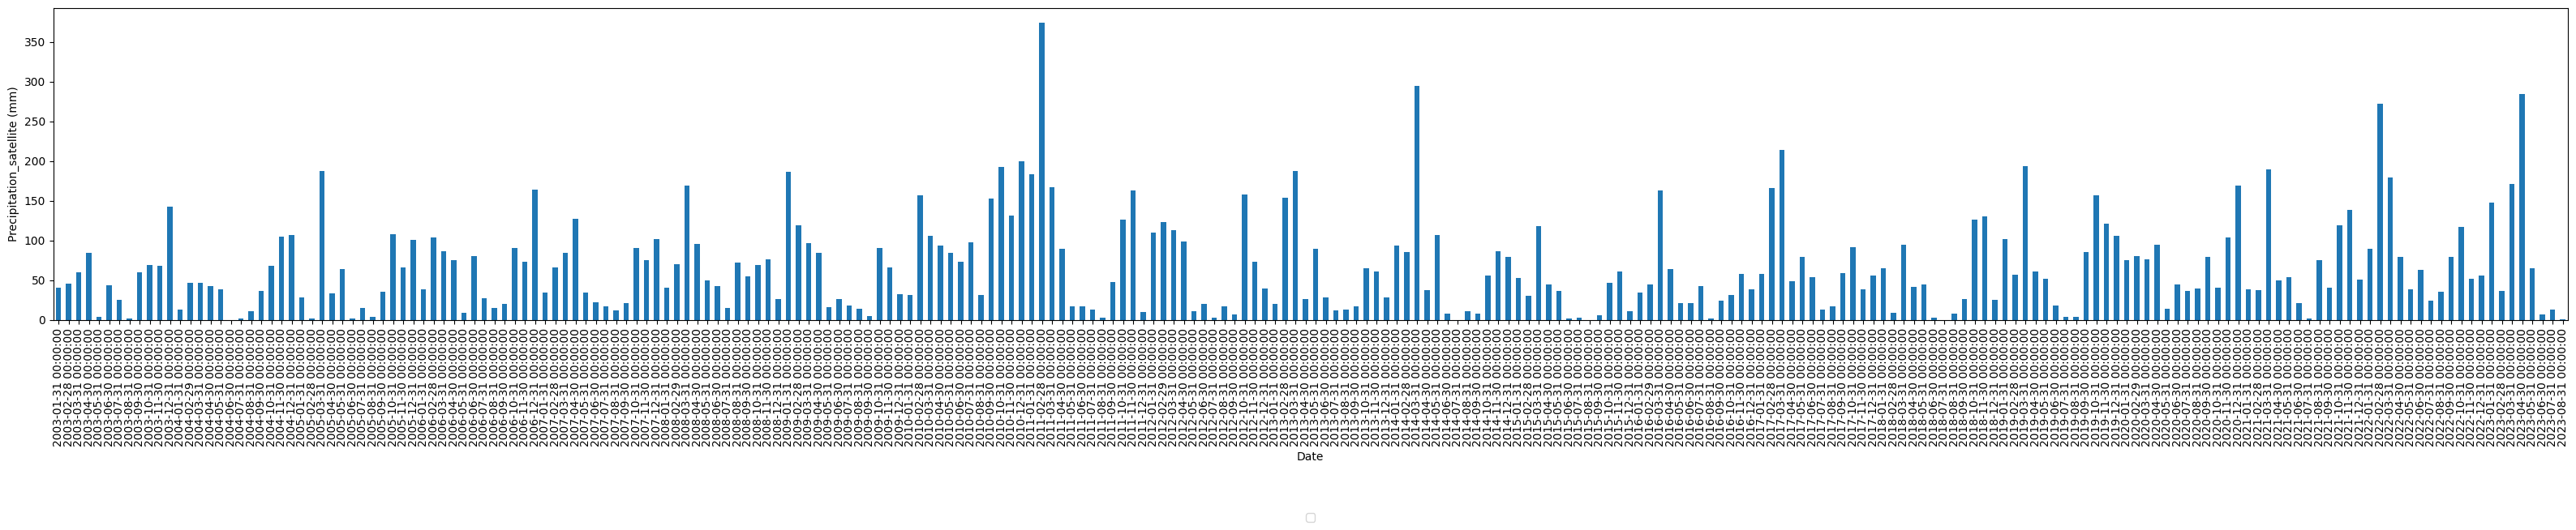

In [24]:
fig, ax = plt.subplots(figsize=(40,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean_pixels.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calculate average monthly precipitation (average of all pixels in the basin).

In [25]:
data_monthly_mean= data_monthly_mean_pixels.groupby(data_monthly_mean_pixels.index.month).mean()
data_monthly_mean

,0
Date,
1,70.852099
2,99.124885
3,142.750617
4,78.946543
5,44.431270
6,28.550265
7,18.388448
8,18.638889
9,43.499741


Plot

<ipython-input-26-c4152e15b20a>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Legend Title')


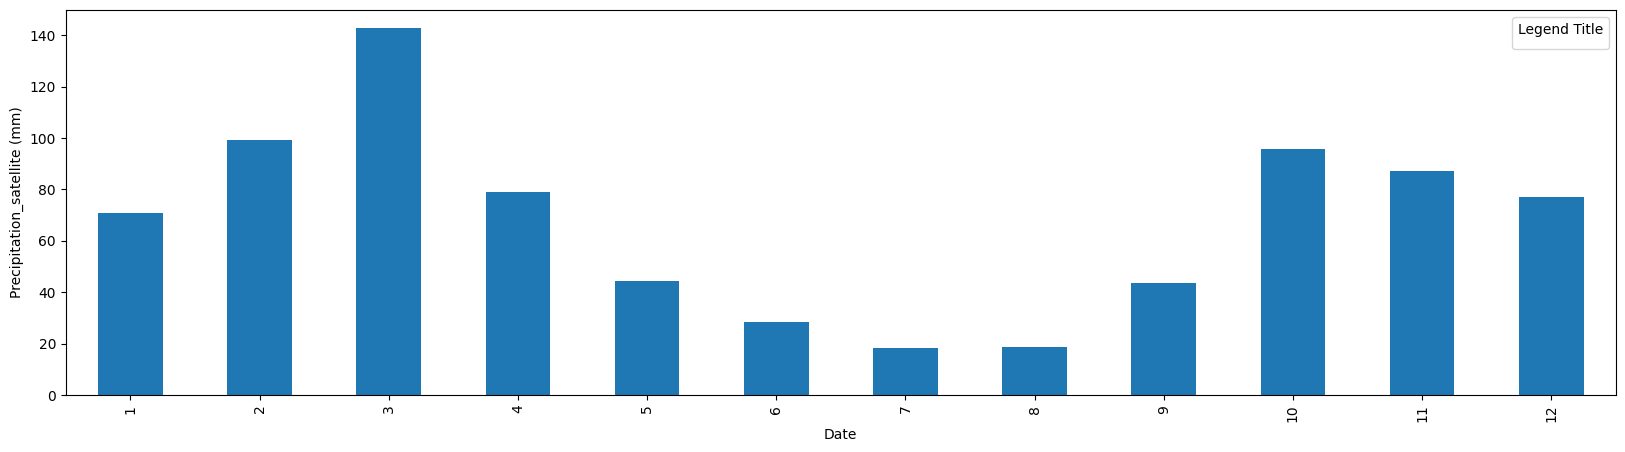

In [26]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
plt.show()

### Import in-situ precipitation

Let's use three rain gauges installed within the catchment.

#### For rain gauge 1
Import and preprocess the data.

In [27]:
folder_pcp_1 = folder+'Rain_gauge_1/'
df_pcp_1= pd.read_table(folder_pcp_1+'Rain_gauge_1.csv', sep=',')
df_pcp_1.rename(columns={'Texas_tip_corrected_mm':'Pluviómetro_1'},inplace=True)
df_pcp_1.columns
df_pcp_1

,Date_yy/mm/dd_hh:mm:ss,Pluviómetro_1
0,2012-10-02 12:00:00,NaN
1,2012-10-02 13:00:00,0.0
2,2012-10-02 14:00:00,0.0
3,2012-10-02 15:00:00,0.0
4,2012-10-02 16:00:00,0.0
...,...,...
95638,2023-08-31 10:00:00,0.0
95639,2023-08-31 11:00:00,0.0
95640,2023-08-31 12:00:00,0.0
95641,2023-08-31 13:00:00,0.0


Operations to organize the information into a manageable dataframe.

In [28]:
# Rename the column 'Date_yy/mm/dd_hh:mm:ss' to 'Date'
df_pcp_1.rename(columns={'Date_yy/mm/dd_hh:mm:ss': 'Date'}, inplace=True)
# Convert the 'Date' column to datetime format
df_pcp_1['Date'] = df_pcp_1['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
# Set the 'Date' column as the index
df_pcp_1.set_index('Date', inplace=True)
df_pcp_1 = df_pcp_1[~df_pcp_1.index.duplicated(keep='first')]

df_pcp_1 = df_pcp_1.sort_index()

df_pcp_1

<ipython-input-28-68531c0871b8>:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_pcp_1['Date'] = df_pcp_1['Date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))


,Pluviómetro_1
Date,
2012-01-11 00:00:00,0.0
2012-01-11 01:00:00,0.0
2012-01-11 02:00:00,0.0
2012-01-11 03:00:00,0.0
2012-01-11 04:00:00,0.0
...,...
2023-12-08 19:00:00,0.0
2023-12-08 20:00:00,0.0
2023-12-08 21:00:00,0.0


Plot the year 2020 from the imported precipitation series.

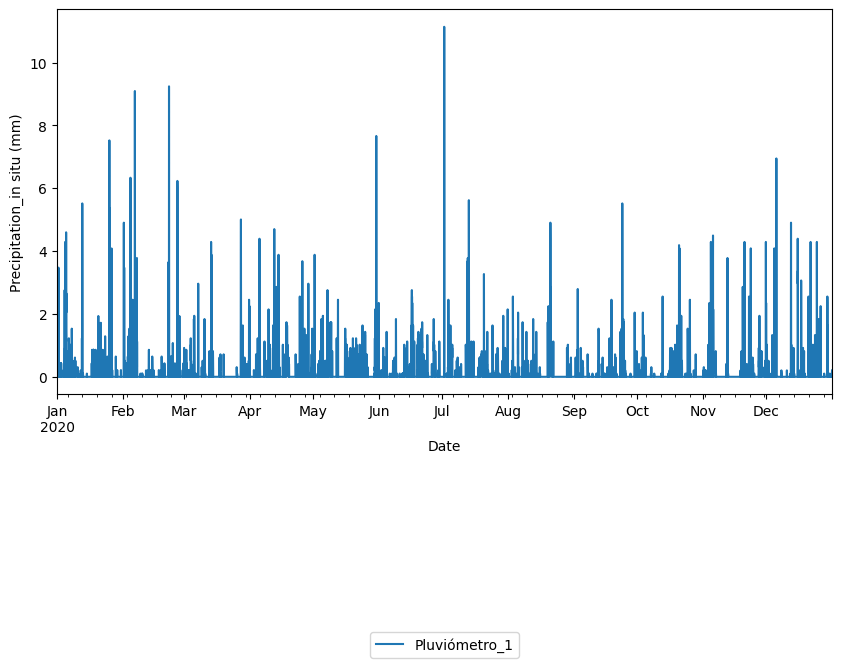

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Plot the accumulated precipitation for 2020 from the imported time series.

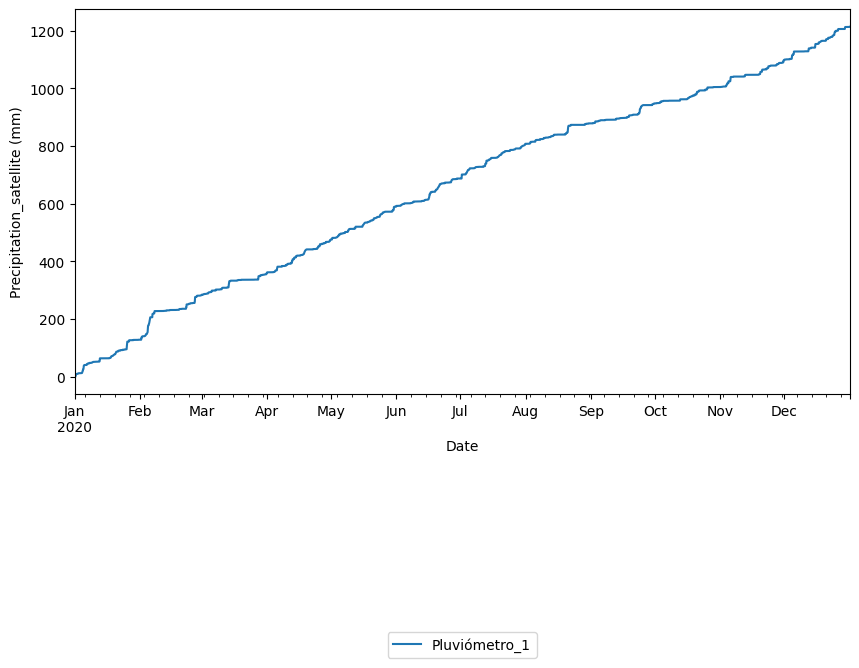

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### For Rain Gauge 2

Import and preprocess the data.

In [31]:
folder_pcp_2 = folder+'Rain_gauge_2/'
df_pcp_2= pd.read_table(folder_pcp_2+'Rain_gauge_2.csv', sep=',')
df_pcp_2

,Date,Precipitation
0,2013-03-07 17:00:00,0.000000
1,2013-03-07 18:00:00,0.000000
2,2013-03-07 19:00:00,0.000000
3,2013-03-07 20:00:00,0.000000
4,2013-03-07 21:00:00,0.000000
...,...,...
94125,2023-12-02 14:00:00,0.000000
94126,2023-12-02 15:00:00,0.000000
94127,2023-12-02 16:00:00,0.000000
94128,2023-12-02 17:00:00,0.000000


Operaciones para crear un dataframe manejable

In [32]:
df_pcp_2['Date'] = df_pcp_2.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_2.set_index(df_pcp_2['Date'],inplace=True)
df_pcp_2.rename(columns={'Precipitation':'Pluviómetro_2'},inplace=True)
df_pcp_2 = df_pcp_2.drop(labels='Date', axis=1)
df_pcp_2 = df_pcp_2[~df_pcp_2.index.duplicated(keep='first')]

df_pcp_2 = df_pcp_2.sort_index()
df_pcp_2

<ipython-input-32-45be547f2094>:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_pcp_2['Date'] = df_pcp_2.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))


,Pluviómetro_2
Date,
2013-01-04 00:00:00,NaN
2013-01-04 01:00:00,NaN
2013-01-04 02:00:00,NaN
2013-01-04 03:00:00,NaN
2013-01-04 04:00:00,NaN
...,...
2023-12-11 19:00:00,0.0
2023-12-11 20:00:00,0.0
2023-12-11 21:00:00,0.0


Plot the year 2020 from the imported series.

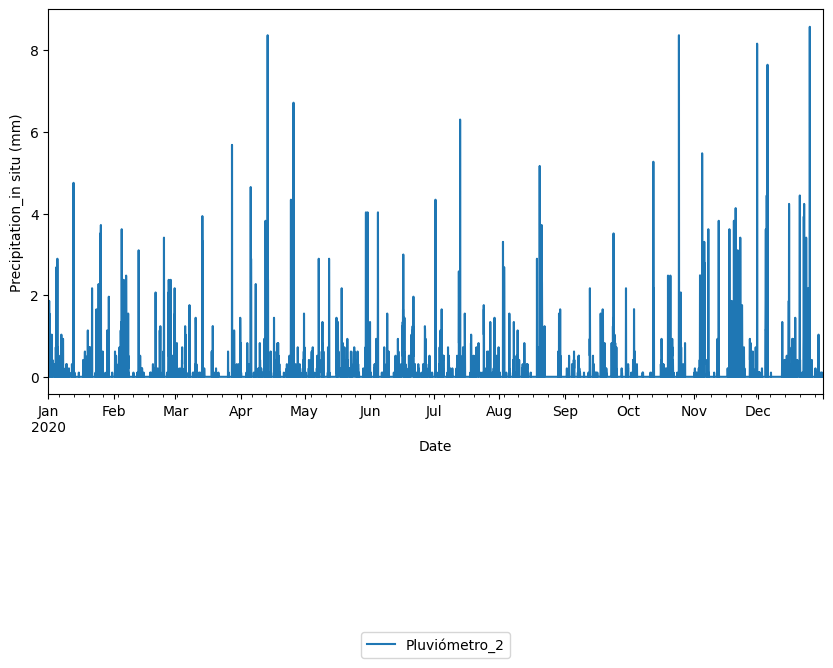

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Plot the accumulated precipitation for the year 2020 from the imported series.

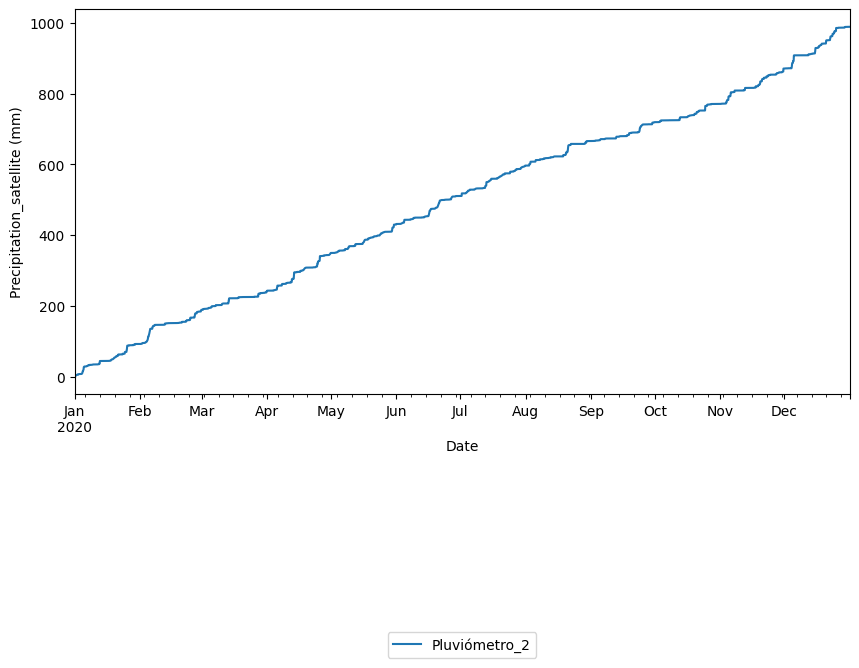

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### For rain gauge 3

Import and preprocess the data.

In [35]:
folder_pcp_3 = folder+'Rain_gauge_3/'
df_pcp_3= pd.read_table(folder_pcp_3+'Rain_gauge_3.csv', sep=',')
df_pcp_3

,Fecha,Precipitation
0,2012-09-27 12:00:00,0.108980
1,2012-09-27 13:00:00,4.904100
2,2012-09-27 14:00:00,2.724500
3,2012-09-27 15:00:00,2.179600
4,2012-09-27 16:00:00,0.544900
...,...,...
97994,2023-12-02 14:00:00,0.000000
97995,2023-12-02 15:00:00,0.245533
97996,2023-12-02 16:00:00,0.000000
97997,2023-12-02 17:00:00,0.000000


Operations to create a manageable dataframe.

In [36]:
df_pcp_3['Fecha'] = df_pcp_3.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_3.set_index(df_pcp_3['Fecha'],inplace=True)
df_pcp_3 = df_pcp_3.drop(labels='Fecha', axis=1)
df_pcp_3.rename(columns={'Precipitation':'Pluviómetro_3'},inplace=True)
df_pcp_3 = df_pcp_3[~df_pcp_3.index.duplicated(keep='first')]

df_pcp_3 = df_pcp_3.sort_index()
df_pcp_3

<ipython-input-36-25fd2f579389>:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_pcp_3['Fecha'] = df_pcp_3.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))


,Pluviómetro_3
Fecha,
2012-01-10 00:00:00,NaN
2012-01-10 01:00:00,NaN
2012-01-10 02:00:00,NaN
2012-01-10 03:00:00,NaN
2012-01-10 04:00:00,NaN
...,...
2023-12-11 19:00:00,0.0
2023-12-11 20:00:00,0.0
2023-12-11 21:00:00,0.0


Plot the precipitation for the year 2020.

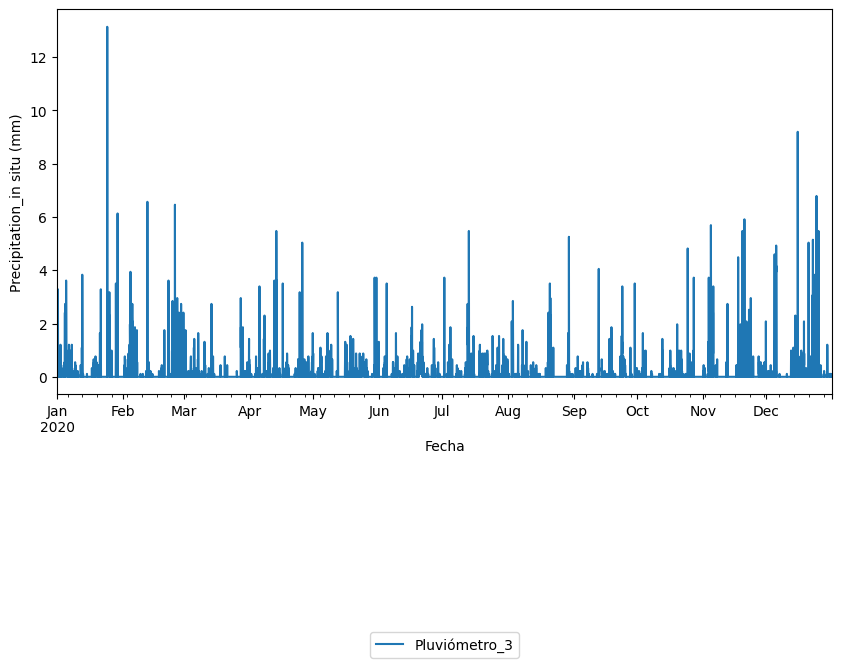

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3.loc['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Plot the accumulated precipitation for the year 2020.

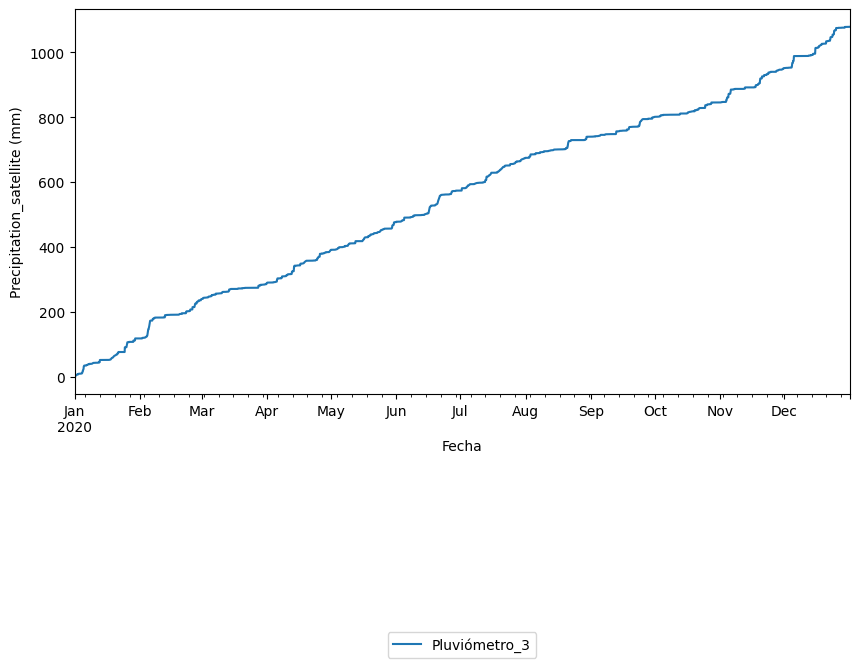

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3.loc['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### Compare the in-situ precipitation

Resample the data from the 3 rain gauges to monthly scales.

In [39]:
df_pcp_1_monthly = df_pcp_1.resample('M',label='right',closed='right').sum()
df_pcp_1_monthly= df_pcp_1_monthly.groupby(df_pcp_1_monthly.index.month).mean()
df_pcp_2_monthly = df_pcp_2.resample('M',label='right',closed='right').sum()
df_pcp_2_monthly= df_pcp_2_monthly.groupby(df_pcp_2_monthly.index.month).mean()
df_pcp_3_monthly = df_pcp_3.resample('M',label='right',closed='right').sum()
df_pcp_3_monthly= df_pcp_3_monthly.groupby(df_pcp_3_monthly.index.month).mean()
all_pcp_monthly = pd.concat([df_pcp_1_monthly, df_pcp_2_monthly, df_pcp_3_monthly], axis=1)

<ipython-input-39-b802d04d31bd>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_pcp_1_monthly = df_pcp_1.resample('M',label='right',closed='right').sum()
<ipython-input-39-b802d04d31bd>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_pcp_2_monthly = df_pcp_2.resample('M',label='right',closed='right').sum()
<ipython-input-39-b802d04d31bd>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_pcp_3_monthly = df_pcp_3.resample('M',label='right',closed='right').sum()


Plot

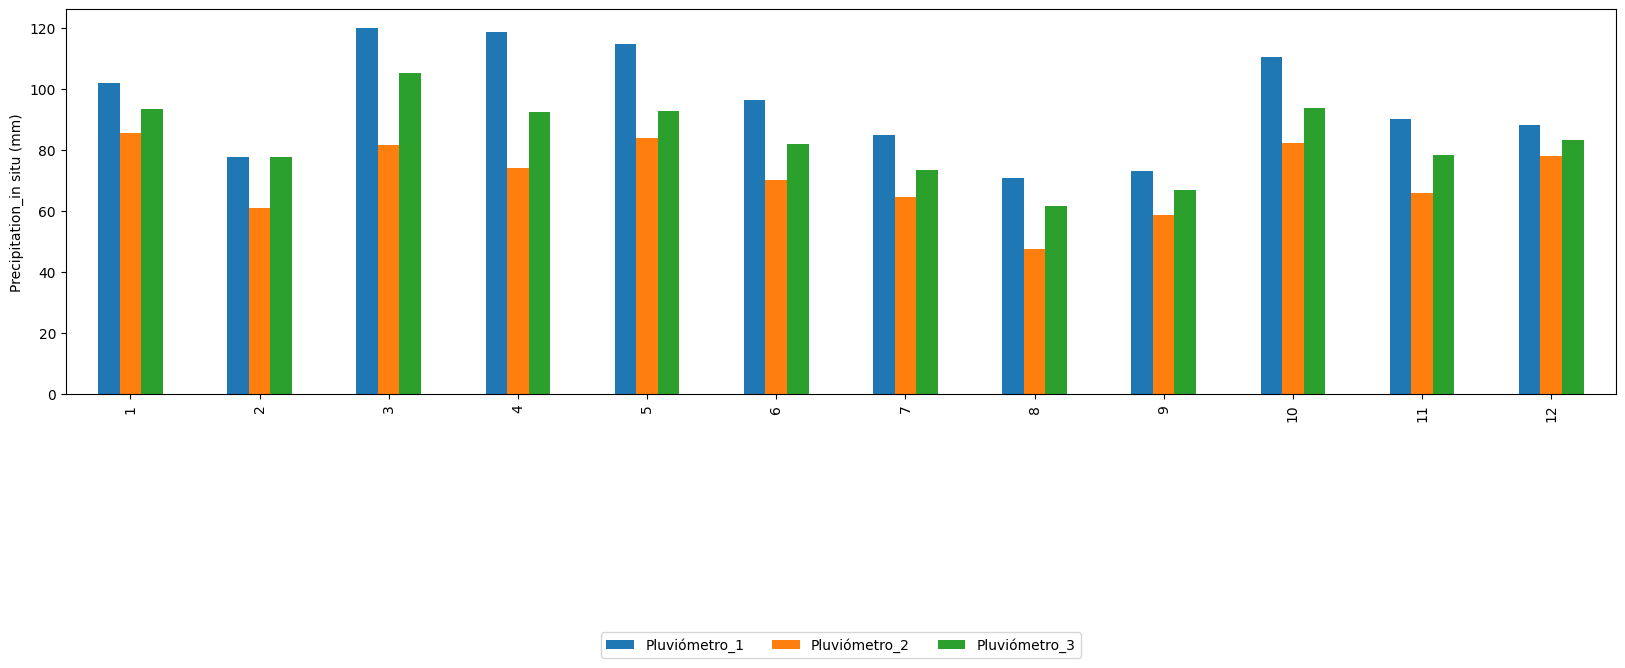

In [40]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
all_pcp_monthly.plot(kind='bar',ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

## Import runoff data

Import and organize runoff data into a manageable dataframe

In [41]:
folder_runoff = folder+'Runoff_catchment_1/'
df_runoff =  pd.read_excel(folder_runoff+'Runoff_catchment_1.xlsx')
df_runoff['Fecha'] = df_runoff.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_runoff.set_index(df_runoff['Fecha'],inplace=True)
df_runoff = df_runoff.drop(labels='Fecha', axis=1)
df_runoff

,Caudal (m3/s)
Fecha,
1997-07-17 20:00:00,5.756145
1997-07-17 21:00:00,5.756145
1997-07-17 22:00:00,5.756145
1997-07-17 23:00:00,5.977188
1997-07-18 00:00:00,5.756145
...,...
2021-07-05 06:59:00,0.738076
2021-07-05 07:59:00,0.738934
2021-07-05 08:59:00,0.736365


Plot

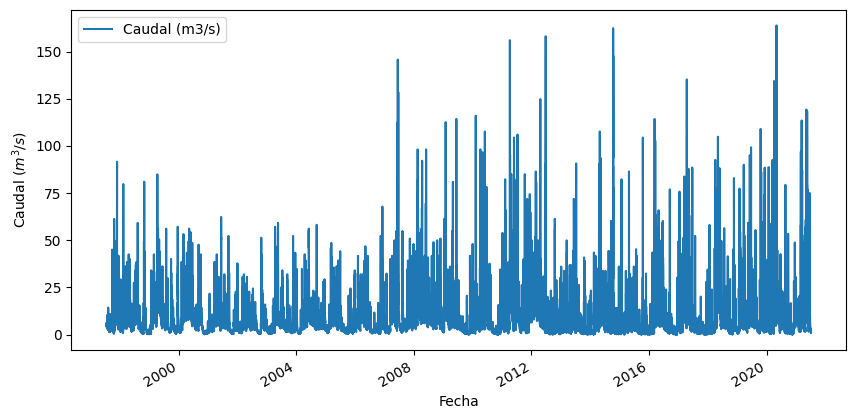

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_runoff.plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')
# Adjusting the position of the legend
plt.legend()
plt.show()


## Combine precipitation (rain gauges + satellite) and flow data for the catchment

In [43]:
df_pcp_1_daily = df_pcp_1.resample('D',label='right',closed='right').sum()
df_pcp_2_daily = df_pcp_2.resample('D',label='right',closed='right').sum()
df_pcp_3_daily = df_pcp_3.resample('D',label='right',closed='right').sum()
df_runoff_daily = df_runoff.resample('D',label='right',closed='right').mean()
all_data_daily = pd.concat([df_pcp_1_daily, df_pcp_2_daily, df_pcp_3_daily, precipitation_satellite, df_runoff_daily], axis=1)
all_data_daily

,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,22,23,24,25,26,27,28,31,32,Caudal (m3/s)
1997-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.800354
1997-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.510110
1997-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.573900
1997-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.166181
1997-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.233679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-08,0.73794,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-09,0.00000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-10,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-11,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Determine periods with concurrent data

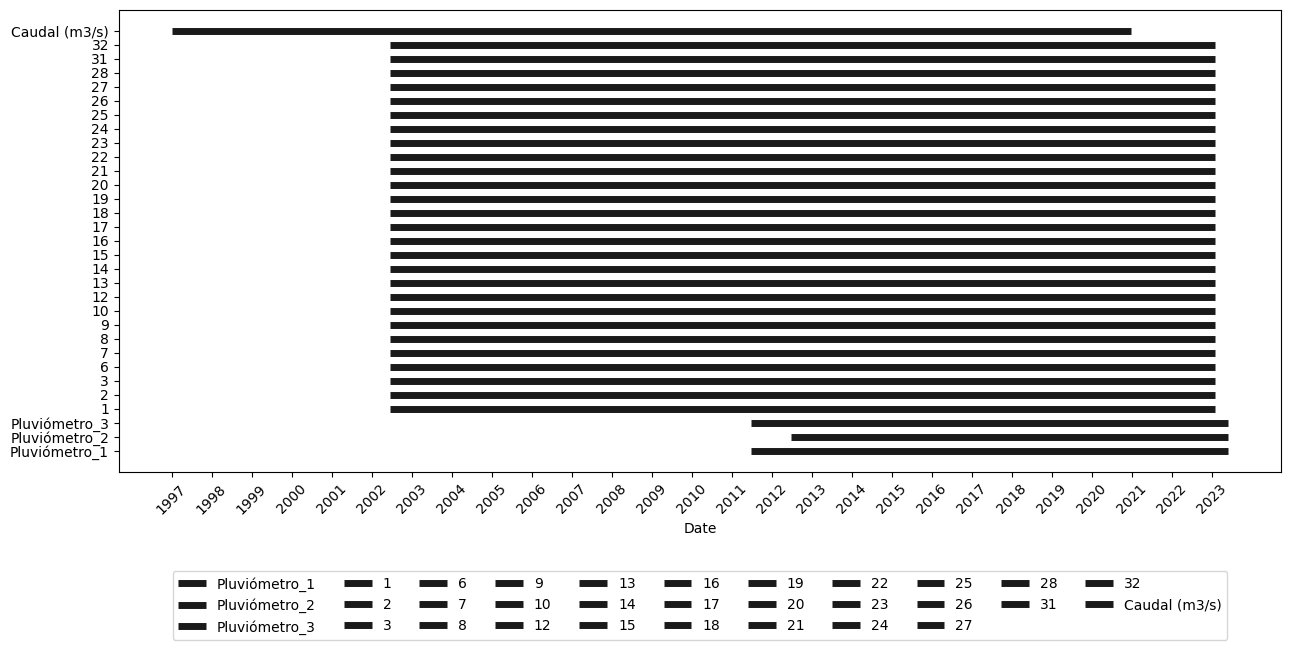

In [44]:
concurrent_periods = all_data_daily.dropna().index

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through columns
for i, col in enumerate(all_data_daily.columns):
    # Get a boolean mask where data is not NaN for the current column
    mask = ~all_data_daily[col].isna()

    # Get the indices of True values in the mask
    indices = np.where(mask)[0]

    # Plot horizontal lines for continuity
    ax.hlines(i, indices[0], indices[-1], colors='0.1', linewidth=5, label=col)

# Set y-ticks and labels
ax.set_yticks(range(len(all_data_daily.columns)))
ax.set_yticklabels(all_data_daily.columns)

# Set x-axis label
ax.set_xlabel('Date')

# Set the x-axis ticks to show years
years = pd.to_datetime(all_data_daily.index).year
unique_years = np.unique(years)
ax.set_xticks(np.arange(len(all_data_daily.index), step=365))
ax.set_xticklabels(unique_years,rotation=45)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=11)

# Show the plot
plt.show()


## Split the data into training and test periods

In [45]:
all_data_daily = all_data_daily[~(all_data_daily.isna().any(axis=1) | (all_data_daily.lt(0).any(axis=1)))]
input_data_train = np.array(all_data_daily['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(all_data_daily['2020':'2021-06'].iloc[:,:-1])

In [ ]:
input_data_train

array([[ 7.1274 ,  0.     ,  4.57716, ...,  0.     ,  0.     ,  0.     ],
       [ 3.86916,  0.10991,  2.07062, ...,  0.     ,  0.     ,  0.     ],
       [ 2.13822,  0.     ,  0.21796, ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 2.0434 ,  5.166  ,  5.91354, ...,  0.     ,  0.     ,  0.     ],
       [ 1.53255,  2.583  ,  1.42363, ...,  0.     ,  0.     ,  0.     ],
       [12.56691,  7.12908,  8.32276, ...,  0.     ,  0.     ,  0.     ]])

In [46]:
output_data_train = np.reshape(np.array(all_data_daily['2013':'2019'].iloc[:,-1]),(all_data_daily['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily['2020':'2021-06'].iloc[:,-1]),(all_data_daily['2020':'2021-06'].shape[0],1))

In [47]:
output_data_train

array([[ 6.436433  ],
       [31.6041108 ],
       [19.21637896],
       ...,
       [ 1.45913546],
       [ 2.10672294],
       [ 3.40283158]])

In [49]:
input_data_train_lags, output_data_train_lags= lagged_dataset(input_data_train, 3, output_data_train,15)

In [50]:
input_data_train_lags

array([[ 0.61092   ,  0.        ,  0.21796   , ...,  2.55601433,
         2.23686872,  3.72926551],
       [11.91294   ,  0.        ,  0.        , ...,  2.23686872,
         3.72926551,  3.36018271],
       [10.38564   ,  0.        ,  1.30776   , ...,  3.72926551,
         3.36018271,  2.06741952],
       ...,
       [ 1.12387   ,  0.30996   ,  0.65706   , ...,  1.66572182,
         1.48337555,  1.68993365],
       [ 1.22604   ,  0.5166    ,  0.76657   , ...,  1.48337555,
         1.68993365,  1.45913546],
       [ 1.32821   ,  2.89296   ,  4.48991   , ...,  1.68993365,
         1.45913546,  2.10672294]])

In [51]:
output_data_train_lags

array([[3.36018271],
       [2.06741952],
       [1.5540511 ],
       ...,
       [1.45913546],
       [2.10672294],
       [3.40283158]])

In [52]:
input_data_test_lags, output_data_test_lags= lagged_dataset(input_data_test, 3, output_data_test,15)

In [53]:
input_data_test_lags

array([[ 0.2149266 ,  0.10332   ,  0.        , ..., 11.6085901 ,
         5.40761042,  4.09615773],
       [ 0.8597064 ,  1.44648   ,  4.3804    , ...,  5.40761042,
         4.09615773,  3.26299964],
       [ 0.2149266 ,  2.0664    ,  6.24207   , ...,  4.09615773,
         3.26299964,  2.38323539],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  5.4826092 ,
         4.08104159,  3.43069775],
       [ 0.84336   ,  1.641795  ,  1.11362   , ...,  4.08104159,
         3.43069775,  2.81574878],
       [ 0.5271    ,  3.830855  ,  4.009032  , ...,  3.43069775,
         2.81574878,  2.05206994]])

In [54]:
output_data_test_lags

array([[3.26299964e+00],
       [2.38323539e+00],
       [2.04150960e+00],
       [2.12740993e+00],
       [1.97586372e+00],
       [1.56266220e+00],
       [1.32490767e+00],
       [9.13074435e-01],
       [7.42564058e-01],
       [7.29255890e-01],
       [7.38267416e-01],
       [7.52041606e-01],
       [5.78568778e-01],
       [4.32383611e-01],
       [4.39384755e-01],
       [4.00086486e-01],
       [3.26506799e-01],
       [2.92573230e-01],
       [2.74681703e-01],
       [2.75181926e-01],
       [3.07345269e-01],
       [3.52692385e-01],
       [3.30488928e-01],
       [5.53051936e-01],
       [2.19522790e+00],
       [3.08987012e+00],
       [2.11562740e+00],
       [6.28034282e+00],
       [2.09868030e+01],
       [8.33435695e+00],
       [3.53802989e+00],
       [2.64702828e+00],
       [2.64398203e+00],
       [4.18060501e+00],
       [2.60989310e+00],
       [2.43471332e+00],
       [3.64091264e+00],
       [4.19450282e+00],
       [1.06584314e+01],
       [5.44914454e+00],


## Creation and training of a Random Forest model (not forecasting)

### Define model hyperparameters

In [55]:
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'

### Define the model

In [56]:
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)

### Train the model

In [57]:
# Correcting the shape of output_data_train_lags
regr = regr.fit(input_data_train_lags, output_data_train_lags.ravel())

### Generate simulations for the training period

In [58]:
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
simulations_data_train

array([[3.92280601],
       [2.87170566],
       [2.04328932],
       ...,
       [2.07890263],
       [2.51929867],
       [3.84898762]])

### Generate simulations for the testing period

In [59]:
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
simulations_data_test

array([[ 7.61182688],
       [ 5.64774886],
       [ 5.8130227 ],
       [ 6.49271746],
       [ 5.28367807],
       [11.32586138],
       [15.3086541 ],
       [10.41879575],
       [ 6.70607372],
       [ 3.92935739],
       [ 1.71643079],
       [ 0.98579051],
       [ 0.80039516],
       [ 0.73271425],
       [ 0.85727324],
       [ 0.6832403 ],
       [ 0.48748325],
       [ 0.37971633],
       [ 0.31984205],
       [ 0.27375454],
       [ 0.39091298],
       [ 1.5176905 ],
       [ 2.0203082 ],
       [ 3.04088934],
       [ 3.83967962],
       [ 3.36932357],
       [ 3.30139683],
       [ 5.40449821],
       [ 8.01357407],
       [10.30850138],
       [ 8.22343811],
       [ 7.06495051],
       [ 5.65416421],
       [ 4.0358875 ],
       [ 3.21697957],
       [ 3.51925286],
       [ 3.2242831 ],
       [ 3.84811019],
       [ 5.77348156],
       [ 8.07325438],
       [ 6.39230919],
       [ 5.36081538],
       [ 7.07385691],
       [10.34407944],
       [13.82149651],
       [13

### Model evaluation

Calculate the correlation coefficients for the training and testing periods.

In [60]:
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.8172467529526818 0.5117278865610209


## Creation and training of a random forest model (forecasting)

### One-day forecasting case

In [61]:
leadtime = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 7, output_data_train,15, lead_time=leadtime)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 7, output_data_test,15, lead_time=leadtime)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=42)
regr=regr.fit(input_data_train_lags, output_data_train_lags.ravel())
#Prediction on training data
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.7849942923943463 0.448496201712819


### Forecasts in the testing period

In [62]:
simulations_data_test

array([[ 7.70883022],
       [ 6.67117911],
       [ 8.53837285],
       [ 6.1499581 ],
       [ 6.82663729],
       [11.57159784],
       [10.66862488],
       [ 6.72612858],
       [ 5.69497491],
       [ 3.25540739],
       [ 1.943905  ],
       [ 1.49169709],
       [ 1.39396577],
       [ 1.15823396],
       [ 0.913134  ],
       [ 0.71992776],
       [ 0.5043554 ],
       [ 0.44014772],
       [ 0.35980854],
       [ 0.32484422],
       [ 1.54293238],
       [ 2.09382598],
       [ 2.16431098],
       [ 4.03111763],
       [ 3.79788429],
       [ 3.37530675],
       [ 4.22263958],
       [ 9.20319805],
       [11.28811671],
       [ 8.47727133],
       [ 8.08314114],
       [ 7.23206716],
       [ 4.55724255],
       [ 4.05446163],
       [ 4.05281886],
       [ 4.02854201],
       [ 3.22823802],
       [ 6.63276167],
       [ 8.12309952],
       [ 5.93575463],
       [ 6.2099527 ],
       [ 7.40057292],
       [ 7.22313891],
       [14.89248457],
       [14.84656067],
       [ 9

### Evaluation using a combination of efficiency metrics

In [63]:
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 8.2647
PBias: 8.7967
KGE: 0.3921
R2: 0.4485


### Evaluation through visual inspection

### One-Day runoff forecasts

In [64]:
simulations_data_test = pd.DataFrame(simulations_data_test, columns=['Forecasts'], index=all_data_daily['2019':'2021-06'].index[-len(simulations_data_test):])
simulations_data_test

,Forecasts
2020-02-01,7.708830
2020-02-02,6.671179
2020-02-03,8.538373
2020-02-04,6.149958
2020-02-05,6.826637
...,...
2021-06-26,6.264015
2021-06-27,5.711932
2021-06-28,5.436211
2021-06-29,4.449057


### And the runoff observations

In [65]:
observations_data_test = pd.DataFrame(output_data_test_lags, columns=['Observations'], index=all_data_daily['2019':'2021-06'].index[-len(output_data_test_lags):])
observations_data_test

,Observations
2020-02-01,2.383235
2020-02-02,2.041510
2020-02-03,2.127410
2020-02-04,1.975864
2020-02-05,1.562662
...,...
2021-06-26,4.081042
2021-06-27,3.430698
2021-06-28,2.815749
2021-06-29,2.052070


### Combine forecasts and observations into a DataFrame

In [66]:
testing_period = pd.concat([simulations_data_test, observations_data_test], axis=1)

In [67]:
testing_period

,Forecasts,Observations
2020-02-01,7.708830,2.383235
2020-02-02,6.671179,2.041510
2020-02-03,8.538373,2.127410
2020-02-04,6.149958,1.975864
2020-02-05,6.826637,1.562662
...,...,...
2021-06-26,6.264015,4.081042
2021-06-27,5.711932,3.430698
2021-06-28,5.436211,2.815749
2021-06-29,4.449057,2.052070


### Plot (compare) forecasts and observations

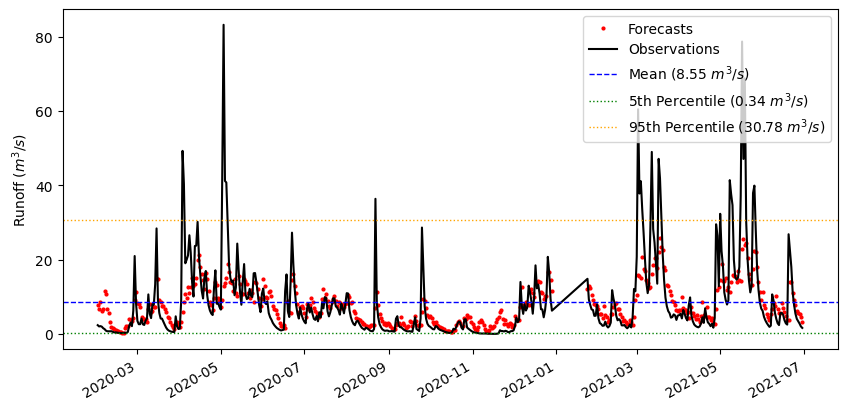

In [68]:

# Calculate mean and percentiles
mean_obs = testing_period['Observations'].mean()
p05 = testing_period['Observations'].quantile(0.05)
p95= testing_period['Observations'].quantile(0.95)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot forecasts and observations
testing_period['Forecasts'].plot(ax=ax, color='red', marker='o', linestyle='', markersize=2, label='Forecasts')
testing_period['Observations'].plot(ax=ax, color='black', linestyle='-', label='Observations')

# Add horizontal lines for mean and percentiles
ax.axhline(mean_obs, color='blue', linestyle='--', linewidth=1, label=f'Mean ({mean_obs:.2f} $m^3/s$)')
ax.axhline(p05, color='green', linestyle=':', linewidth=1, label=f'5th Percentile ({p05:.2f} $m^3/s$)')
ax.axhline(p95, color='orange', linestyle=':', linewidth=1, label=f'95th Percentile ({p95:.2f} $m^3/s$)')

# Add labels and legend
ax.set_ylabel('Runoff ($m^3/s$)')
ax.legend(loc='upper right')

# Display the plot
plt.show()


### Scatter plot of forecasts and observations

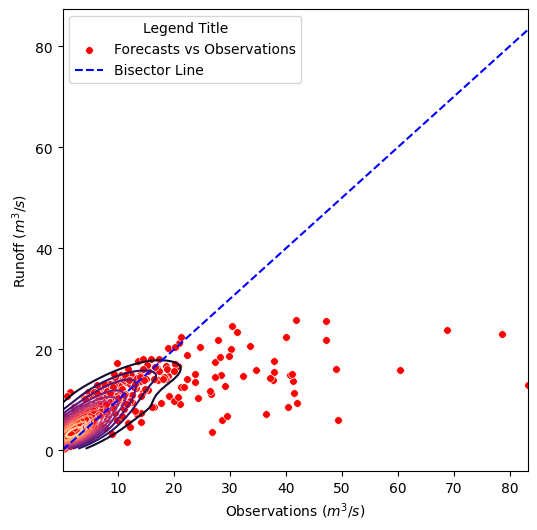

In [71]:
from scipy.stats import gaussian_kde


# Step 1: Clean the data to handle NaN and Inf values
testing_period = testing_period.replace([np.inf, -np.inf], np.nan).dropna(subset=['Observations', 'Forecasts'])

# Step 2: Scatter plot data
x = testing_period['Observations'].values
y = testing_period['Forecasts'].values

# Step 3: Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for Observations vs Forecasts
sns.scatterplot(x=x, y=y, color='red', marker='o', s=30, label='Forecasts vs Observations', ax=ax)

# Step 4: KDE using scipy's gaussian_kde
# Create grid for KDE
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Perform KDE
kde = gaussian_kde(np.vstack([x, y]))
density = np.reshape(kde(positions).T, xx.shape)

# Plot KDE contours
ax.contour(xx, yy, density, levels=13, cmap='magma')

# Step 5: Add bisector line (y = x)
min_val = min(xmin, ymin)
max_val = max(xmax, ymax)
ax.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Bisector Line')

# Step 6: Add labels and legend
ax.legend(title='Legend Title')
ax.set_xlabel('Observations ($m^3/s$)')
ax.set_ylabel('Runoff ($m^3/s$)')

# Show the plot
plt.show()




## Include ENSO data

https://psl.noaa.gov/gcos_wgsp/Timeseries/

Import data

In [72]:
# Define the path to
folder_nino12 = folder+'ENSO/nino12.long.anom.data.xlsx'
folder_nino3 = folder+'ENSO/nino3.long.anom.data.xlsx'
folder_nino34 = folder+'ENSO/nino34.long.anom.data.xlsx'


In [73]:
# Use tabula to extract tables
nino12 =  pd.read_excel(folder_nino12)
nino3 =  pd.read_excel(folder_nino3)
nino34 =  pd.read_excel(folder_nino34)

In [74]:
# Melt the DataFrame to convert it to long format
nino12_long = nino12.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino12_long['Data'] = nino12_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino12_long['Date'] = pd.to_datetime(nino12_long['Year'].astype(str) + '-' + nino12_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino12_time_series = nino12_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino12_time_series

# Melt the DataFrame to convert it to long format
nino3_long = nino3.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino3_long['Data'] = nino3_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino3_long['Date'] = pd.to_datetime(nino3_long['Year'].astype(str) + '-' + nino3_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino3_time_series = nino3_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino3_time_series

# Melt the DataFrame to convert it to long format
nino34_long = nino34.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino34_long['Data'] = nino34_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino34_long['Date'] = pd.to_datetime(nino34_long['Year'].astype(str) + '-' + nino34_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino34_time_series = nino34_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino34_time_series

,Data
Date,
1870-01-01,-1.00
1871-01-01,-0.25
1872-01-01,-0.72
1873-01-01,-0.78
1874-01-01,-0.93
...,...
2019-12-01,0.51
2020-12-01,-0.98
2021-12-01,-1.07


### Convert monthly data to daily data

In [75]:
nino12_df = nino12_time_series.resample('D').ffill()
nino3_df = nino3_time_series.resample('D').ffill()
nino34_df = nino34_time_series.resample('D').ffill()

In [76]:
ENSO_daily = pd.concat([nino12_df,nino3_df,nino34_df], axis=1)
ENSO_daily

,Data,Data,Data
Date,,,
1870-01-01,-1.5,-1.35,-1.0
1870-01-02,-1.5,-1.35,-1.0
1870-01-03,-1.5,-1.35,-1.0
1870-01-04,-1.5,-1.35,-1.0
1870-01-05,-1.5,-1.35,-1.0
...,...,...,...
2023-11-27,NaN,NaN,NaN
2023-11-28,NaN,NaN,NaN
2023-11-29,NaN,NaN,NaN


### Combine all Information

In [77]:
all_data_daily_ENSO = pd.concat([all_data_daily, ENSO_daily], axis=1)
all_data_daily_ENSO

,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,25,26,27,28,31,32,Caudal (m3/s),Data,Data,Data
1870-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
all_data_daily_ENSO.loc['2013']

,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,25,26,27,28,31,32,Caudal (m3/s),Data,Data,Data
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
2013-01-04,7.12740,0.00000,4.57716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.436433,-0.70,-0.59,-0.42
2013-01-05,3.86916,0.10991,2.07062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,31.604111,-0.70,-0.59,-0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.215175,-0.25,-0.02,-0.09
2013-12-28,0.40728,0.43964,0.98082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.150495,-0.25,-0.02,-0.09
2013-12-29,0.61092,0.21982,0.21796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.128070,-0.25,-0.02,-0.09
2013-12-30,2.44368,2.30811,2.28858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125228,-0.25,-0.02,-0.09


### Define training and testing periods

In [79]:
all_data_daily_ENSO = all_data_daily_ENSO[~(all_data_daily_ENSO.isna().any(axis=1))]
all_data_daily_ENSO.shape
inputs = all_data_daily_ENSO.drop(all_data_daily_ENSO.columns[-4], axis=1)
input_data_train = np.array(inputs['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(inputs['2020':'2021-06'].iloc[:,:-1])
output_data_train = np.reshape(np.array(all_data_daily_ENSO['2013':'2019'].iloc[:,-4]),(all_data_daily_ENSO['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily_ENSO['2020':'2021-06'].iloc[:,-4]),(all_data_daily_ENSO['2020':'2021-06'].shape[0],1))

In [80]:
input_data_train

array([[ 7.1274 ,  0.     ,  4.57716, ...,  0.     , -0.7    , -0.59   ],
       [ 3.86916,  0.10991,  2.07062, ...,  0.     , -0.7    , -0.59   ],
       [ 2.13822,  0.     ,  0.21796, ...,  0.     , -0.7    , -0.59   ],
       ...,
       [ 2.0434 ,  5.166  ,  5.91354, ...,  0.     , -0.19   ,  0.25   ],
       [ 1.53255,  2.583  ,  1.42363, ...,  0.     , -0.19   ,  0.25   ],
       [12.56691,  7.12908,  8.32276, ...,  0.     , -0.19   ,  0.25   ]])

In [81]:
output_data_test

array([[1.53248767e+01],
       [1.58211567e+01],
       [1.42347386e+01],
       [1.26846169e+01],
       [6.87607984e+00],
       [4.76350963e+00],
       [4.18824255e+00],
       [3.38542495e+00],
       [4.93260764e+00],
       [4.85179543e+00],
       [1.79362249e+01],
       [2.34326570e+01],
       [1.16085901e+01],
       [5.40761042e+00],
       [4.09615773e+00],
       [3.26299964e+00],
       [2.38323539e+00],
       [2.04150960e+00],
       [2.12740993e+00],
       [1.97586372e+00],
       [1.56266220e+00],
       [1.32490767e+00],
       [9.13074435e-01],
       [7.42564058e-01],
       [7.29255890e-01],
       [7.38267416e-01],
       [7.52041606e-01],
       [5.78568778e-01],
       [4.32383611e-01],
       [4.39384755e-01],
       [4.00086486e-01],
       [3.26506799e-01],
       [2.92573230e-01],
       [2.74681703e-01],
       [2.75181926e-01],
       [3.07345269e-01],
       [3.52692385e-01],
       [3.30488928e-01],
       [5.53051936e-01],
       [2.19522790e+00],


## Development of one-day forecasting models

In [82]:
leadtime = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 3, output_data_train,15, lead_time=leadtime)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 3, output_data_test,15, lead_time=leadtime)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)
regr=regr.fit(input_data_train_lags, output_data_train_lags.ravel())
#Prediction on training data
simulations_data_train_ENSO= regr.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= regr.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.7959118552033245 0.47889697611722915


### Evaluation with efficiency metrics

In [83]:
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test_ENSO, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 8.0337
PBias: 10.5914
KGE: 0.4227
R2: 0.4789


### Visual inspection

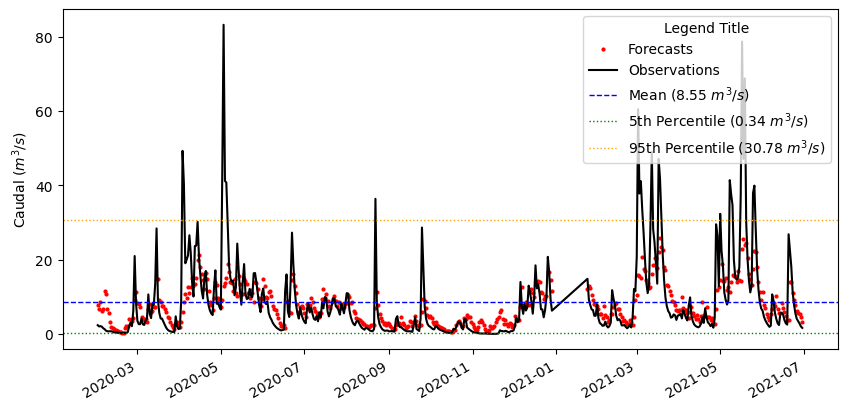

In [84]:
simulations_data_test_ENSO = pd.DataFrame(simulations_data_test, columns=['Forecasts'], index=all_data_daily['2019':'2021-06'].index[-len(simulations_data_test):])
observations_data_test_ENSO = pd.DataFrame(output_data_test_lags, columns=['Observations'], index=all_data_daily['2019':'2021-06'].index[-len(output_data_test_lags):])
testing_period_ENSO = pd.concat([simulations_data_test_ENSO, observations_data_test_ENSO], axis=1)


# Calculate mean and percentiles for Observations
mean_obs = testing_period_ENSO['Observations'].mean()
p05 = testing_period_ENSO['Observations'].quantile(0.05)
p95 = testing_period_ENSO['Observations'].quantile(0.95)

# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

# Plot Forecasts and Observations
testing_period_ENSO['Forecasts'].plot(ax=ax, color='red', marker='o', linestyle='', markersize=2, label='Forecasts')
testing_period_ENSO['Observations'].plot(ax=ax, color='black', linestyle='-', label='Observations')

# Add horizontal lines for mean and percentiles
ax.axhline(mean_obs, color='blue', linestyle='--', linewidth=1, label=f'Mean ({mean_obs:.2f} $m^3/s$)')
ax.axhline(p05, color='green', linestyle=':', linewidth=1, label=f'5th Percentile ({p05:.2f} $m^3/s$)')
ax.axhline(p95, color='orange', linestyle=':', linewidth=1, label=f'95th Percentile ({p95:.2f} $m^3/s$)')

# Adding labels for the legend
ax.legend(title='Legend Title', loc='upper right')

# Adding a label to the y-axis
ax.set_ylabel('Caudal ($m^3/s$)')

# Display the plot
plt.show()

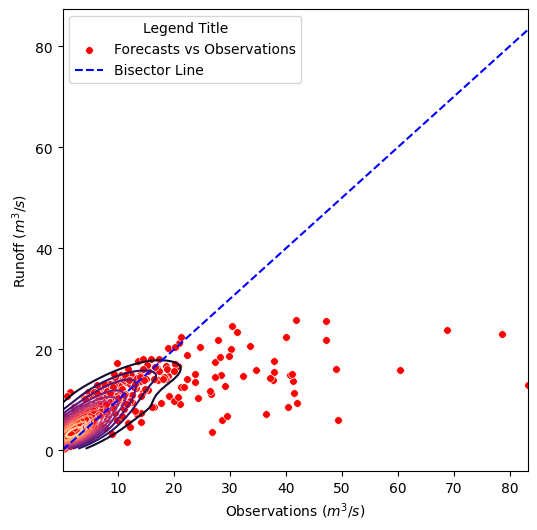

In [85]:

# Step 1: Clean the data (replace inf with NaN, drop NaNs)
testing_period_ENSO = testing_period_ENSO.replace([np.inf, -np.inf], np.nan).dropna(subset=['Observations', 'Forecasts'])

# Step 2: Scatter plot data
x = testing_period_ENSO['Observations'].values
y = testing_period_ENSO['Forecasts'].values

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for Observations vs Forecasts
sns.scatterplot(x=x, y=y, color='red', marker='o', s=30, label='Forecasts vs Observations', ax=ax)

# Step 3: KDE using scipy's gaussian_kde
# Create grid for KDE
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Perform KDE
kde = gaussian_kde(np.vstack([x, y]))
density = np.reshape(kde(positions).T, xx.shape)

# Plot KDE contours
ax.contour(xx, yy, density, levels=13, cmap='magma')

# Step 4: Add bisector line (y = x)
min_val = min(xmin, ymin)
max_val = max(xmax, ymax)
ax.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Bisector Line')

# Step 5: Add labels and legend
ax.legend(title='Legend Title')
ax.set_xlabel('Observations ($m^3/s$)')
ax.set_ylabel('Runoff ($m^3/s$)')

# Show the plot
plt.show()

## Hyperparameter tuning of the forecasting model

### Define hyperparameter search domain

In [86]:
# Define the parameter grid
param_grid = {
    'min_samples_split': [ 10, 20],
    'min_samples_leaf': [2, 10],
    'max_depth': [100, 300],
    'n_estimators': [100, 300],
    'max_features': ['sqrt','log2']
}

# Calculate the total number of combinations
total_combinations = len(list(itertools.product(*param_grid.values())))

total_combinations

32

### Search for the best hyperparameter combination

In [87]:
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(oob_score=True, n_jobs=-1, warm_start=True),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV to your data
grid_search.fit(input_data_train_lags, output_data_train_lags.ravel())

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)


Best Hyperparameters:
{'max_depth': 300, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


### A more rigorous hyperparameterization

In [ ]:
# Define the parameter grid
param_grid = {
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8],
    'max_depth': [100, 200, 350],
    'n_estimators': [200, 300, 400, 500, 600],
    'max_features': ['auto', 'sqrt','log2']
}
# Calculate the total number of combinations
total_combinations = len(list(itertools.product(*param_grid.values())))

total_combinations
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(oob_score=True, n_jobs=-1, warm_start=True),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV to your data
grid_search.fit(input_data_train_lags, output_data_train_lags.ravel())

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

In [88]:
best_model
simulations_data_train_ENSO= best_model.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= best_model.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
#Nash_Sutcliffe
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.7959118552033245 0.4788969761172289


In [89]:
best_model


RandomForestRegressor(max_depth=300, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_jobs=-1, oob_score=True,
                      warm_start=True)

In [90]:
leadtime = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 3, output_data_train,15, lead_time=leadtime)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 3, output_data_test,15, lead_time=leadtime)
min_samples_splt=10
min_samples_lf=2
max_dpth=300
n_trees=300
max_ft='sqrt'
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)
regr=regr.fit(input_data_train_lags, output_data_train_lags.ravel())
#Prediction on training data
simulations_data_train_ENSO= regr.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= regr.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test_ENSO, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

0.8298536025819403 0.48745335515735944
RMSE: 7.9674
PBias: 8.8780
KGE: 0.4404
R2: 0.4875
